<center><h1 style= "background-color: powderblue;"> MPEG-7 Classification Example using Deep Learning and Fine-tuning </h1></center>

In this page, we aim to classify the images from MPEG7 Shape database using the neural network library Keras. The pre-trained model chosen for this task is the <b><i>InceptionV3</i></b> [1] with weights trained on the ImageNet dataset.

<br>
The following steps are required for following this example:
<ul>
    <li>Install SARpy's requirements: scikit-learn (http://scikit-learn.org/) and NumPy</li>
    <li>Install `pandas` and/or `matplotlib` for better visualization of results <b>(Optional)</b></li>
    
    <li>Install Keras (https://keras.io/)</li>
    <li>Download the weights files for the pre-trained network(s) (which will be done automatically when you import and instantiate the respective network architecture)</li>
</ul>

The MPEG-7 Shape dataset is avaliable in: http://www.dabi.temple.edu/~shape/MPEG7/dataset.html, and also through SARpy's datasets module.


<hr style="height:1px; border:none; color:#0000; background-color:#000; margin: 0 auto;">

## Setup Workspace
Importing Python packages, functions and classes:

In [1]:
import sys
sys.path.append('../../')

# Numpy array library
import numpy as np
# Matplotlib plotting library
import matplotlib.pyplot as plt
# Pandas data library
import pandas as pd
# IPython Display 
from IPython.display import display

# Scikit-learn dataset splitting and model evaluation methods
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Scikit-image resizing and conversion methods
from skimage import io
from skimage.transform import resize
from skimage.color import gray2rgb

# SARpy dataset loading
import sarpy as sp
from sarpy.datasets import load_mpeg7, get_class_name

# Keras deep-learning model methods and classes
import keras
import keras.applications.inception_v3 as inception
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

<hr style="height:1px; border:none; color:#0000; background-color:#000; margin: 0 auto;">


## Data Loading, Normalization and Preprocessing
From SARpy, we load the MPEG7 dataset images through the function <i>datasets.load_mpeg7</i>. The InceptionV3 model requires all images to be of the same dimensions and have three channels; in the original model, the required dimensions were 299x299x3. We resize all of the dataset images to these dimensions, and convert them to three-channel RGB.

In [2]:
# Loading dataset
dataset = load_mpeg7()
bitmaps, targets = dataset["bitmaps"], dataset["targets"]

# Displaying load information
number_of_classes = len(np.unique(targets))
print("Loaded dataset: {} examples, {} classes".format(len(bitmaps), number_of_classes))

Loaded dataset: 1400 examples, 70 classes


<br>
Here we can check some <b>images</b> and their corresponding class from the <b>MPEG7 dataset</b>:

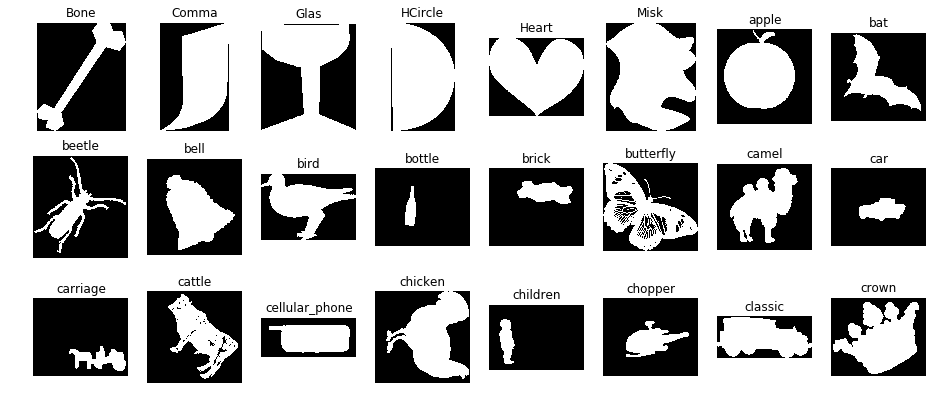

In [3]:
n_cols, n_rows = (8,3)
# Setting size of plot
plt.figure(figsize=(2. * n_cols, 2.26 * n_rows))
    
# Plotting each image with their class as title
col, row = (0,0)
for k in range (0, n_cols * n_rows):
    index = np.where(dataset['targets'] == k)[0]

    ax1 = plt.subplot(n_rows,n_cols,k + 1)
    ax1.imshow(dataset['bitmaps'][index[0]], cmap='gray')
    ax1.set_title(get_class_name('mpeg7',dataset['targets'][index[0]]))
    ax1.axis('off')
        
plt.show()

In [4]:
# Normalizing images
image_size_height = image_size_width = 299
X = [image.img_to_array(gray2rgb(resize(bitmap.data, (299,299), mode="constant"))) for bitmap in bitmaps]
# Converting target labels to one-hot lists
y = keras.utils.to_categorical(targets, num_classes=number_of_classes)

<br>
The data is then split into a training set and a testing set.

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=42)
# Converting lists to numpy arrays
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
# Reporting information on the split dataset
print("Split X and Y into train (shapes: {},{}) and test (shape: {},{})".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Split X and Y into train (shapes: (700, 299, 299, 3),(700, 70)) and test (shape: (700, 299, 299, 3),(700, 70))


<hr style="height:1px; border:none; color:#0000; background-color:#000; margin: 0 auto;">

## Model Training

The <b>InceptionV3</b> model has trained weights for image classification on ImageNet. To fit this model for the new task (identify our own dataset images), we replace the top, fully-connected layers of the original model, and train these new layers with our own data. This is called <b>fine-tuning</b> a pre-trained network.
<br><br>
Further information is available on https://keras.io/applications/#inceptionv3.

In [6]:
# loading the base pre-trained model, without the top layers
base_model = inception.InceptionV3(weights='imagenet', include_top=False)

# Now we replace the top layers with our own.
# First, we add a pooling layer from the output of the existing model:
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Then, we add a 1024-neuron fully connected layer - this is the layer
# that will learn to predict our classes, hopefully
x = Dense(1024, activation='relu')(x)

# Finally, we add a 70-neuron layer, where each neuron corresponds to
# to a single class probability
predictions = Dense(number_of_classes, activation='softmax')(x)

# This is the model we will train: the same input as the base model,
# but outputting to our new top layers 
model = Model(inputs=base_model.input, outputs=predictions)

# We want to train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# Now, we compile the model with a RMSProp optimizer, and with cross-entropy
# as our loss function.
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit(X_train,y_train,batch_size=32, epochs=10);

Epoch 1/10
700/700 [==============================] - 347s - loss: 4.9355 - acc: 0.1071    
Epoch 2/10
700/700 [==============================] - 329s - loss: 2.7017 - acc: 0.3486    
Epoch 3/10
700/700 [==============================] - 317s - loss: 1.6335 - acc: 0.6371    
Epoch 4/10
700/700 [==============================] - 312s - loss: 1.1020 - acc: 0.7471    
Epoch 5/10
700/700 [==============================] - 312s - loss: 0.7654 - acc: 0.8100    
Epoch 6/10
700/700 [==============================] - 314s - loss: 0.4804 - acc: 0.8843    
Epoch 7/10
700/700 [==============================] - 314s - loss: 0.5070 - acc: 0.8900    
Epoch 8/10
700/700 [==============================] - 319s - loss: 0.2311 - acc: 0.9471    
Epoch 9/10
700/700 [==============================] - 315s - loss: 0.3016 - acc: 0.9286    
Epoch 10/10
700/700 [==============================] - 333s - loss: 0.2735 - acc: 0.9229    


<hr style="height:1px; border:none; color:#0000; background-color:#000; margin: 0 auto;">

# Results
Let's compute the model's accuracy, average precision and average recall on the test set.

In [8]:
predict_proba = model.predict(X_test)
y_pred = [np.argmax(x) for x in predict_proba]
y_true = [np.argmax(x) for x in y_test]

print("Accuracy:", accuracy_score(y_pred, y_true))
print("Precision:", precision_score(y_pred, y_true, average='macro'))
print("Recall:", recall_score(y_pred, y_true, average='macro'))

Accuracy: 0.638571428571
Precision: 0.647960888318
Recall: 0.774363466068


In [9]:
cm = confusion_matrix(y_pred, y_true)

data_frame = pd.DataFrame(cm)
data_frame.columns = [ "[{:02}]".format(x) for x in range(number_of_classes)]
data_frame.index = [get_class_name('mpeg7',x) + " [{:02}]".format(x) for x in range(number_of_classes)]
display(data_frame)

,[00],[01],[02],[03],[04],[05],[06],[07],[08],[09],...,[60],[61],[62],[63],[64],[65],[66],[67],[68],[69]
Bone [00],6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Comma [01],0,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Glas [02],0,0,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HCircle [03],0,0,0,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Heart [04],0,0,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Misk [05],0,0,0,0,0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
apple [06],0,0,0,0,0,0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bat [07],0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
beetle [08],0,0,0,0,0,0,0,2,8,0,...,0,0,0,0,0,0,0,0,1,0
bell [09],0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,1


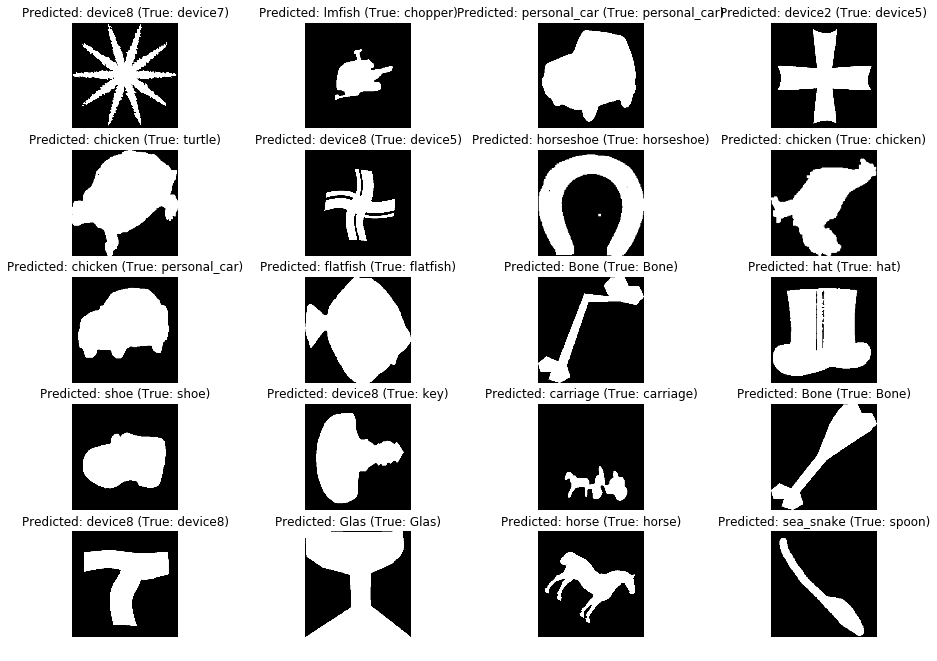

In [12]:
# Display some results
n_rows, n_cols = (5,4)
n = n_rows*n_cols
k = 0

plt.figure(figsize=(4. * n_cols, 2.26 * n_rows))
for test_image, test_target in zip(X_test[::int(len(X_test)/n)], y_test[::int(len(y_test)/n)]):
    # Predicting class
    predicted_class = model.predict(np.array([test_image]))[0]
    
    try:
        ax1 = plt.subplot(n_rows,n_cols,k+1)
        ax1.imshow(test_image, cmap='gray')
        title = "Predicted: {} (True: {})".format(get_class_name('mpeg7',np.argmax(predicted_class)), get_class_name('mpeg7',np.argwhere(test_target)[0][0]))
        ax1.set_title(title)
        ax1.axis('off')    
    
        k = k + 1
        plt.imshow(test_image, cmap='gray')
        plt.axis('off')
    except:
        pass
plt.show()

<hr style="height:1px; border:none; color:#0000; background-color:#000; margin: 0 auto;">

# Tutorial Video 
Check our tutorial video below!

In [14]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/vXwslwkLK4Y?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

<hr style="height:1px; border:none; color:#0000; background-color:#000; margin: 0 auto;">

## References
[1] Szegedy et al. Rethinking the Inception Architecture for Computer Vision. 2015. arXiv:1512.00567 [cs.CV]